In [39]:
from NID.datasets import Pinky40
from NID.models import DnCNN
from NID.utils import weights_init_kaiming, batch_PSNR

import numpy as np
import scipy.io as sio 
import matplotlib.pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable
from dataclasses import dataclass

import os
import h5py
import random
import cv2
import torch 
import torch.nn as nn 
import torch.optim as optim
import torchvision.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from tensorboardX import SummaryWriter 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

@dataclass
class training_configurations: 
    '''class for storing options of the netowrk training'''
    preprocess: bool = False  
    batchSize: int = 256    # training batch size 
    num_of_layers: int = 3 # number of total layers 
    epochs: int = 3   #number of training epochs 
    milestone: int = 1 # when to decay learning rate 
    lr: float = 1e-3  # initial learning rate 
    outf: str = 'logs' #path of log files 
    mode: str = 'M' #with known noise level (S) or blind training (B)
    noiseL: float = 0.1 # noise level
    val_noiseL: float = 0.2 # nosie level used on validation set 

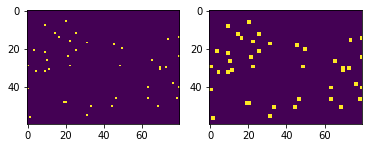

In [76]:
import cv2
kernel = np.ones((2, 2), np.uint8) 

img = torch.rand((60, 80))>0.99
img_dilation = cv2.dilate(img.numpy(), kernel) 
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(img_dilation)

# prepare data

In [40]:
dataset_train = Pinky40(train=True, patch=29)
print(type(dataset_train))
dataset_val = Pinky40(train=False)
loader_train = DataLoader(dataset=dataset_train, num_workers=4, 
                         batch_size=256, shuffle=True)
print("# of training samples: %d\n" % len(dataset_train))
print("# of testing samples: %d\n" % len(dataset_val))

<class 'NID.datasets.Pinky40'>
# of training samples: 194581

# of testing samples: 311



# configure training options

In [41]:
opt = training_configurations()
opt

training_configurations(preprocess=False, batchSize=256, num_of_layers=3, epochs=3, milestone=1, lr=0.001, outf='logs', mode='M', noiseL=0.1, val_noiseL=0.2)

# build model 

In [42]:


net = DnCNN(channels=1, num_of_layers=opt.num_of_layers)
# Move to GPU
device_ids = [0]
#initialize weights
file_results = os.path.join(opt.outf, 'net_{}_state0.pth'.format(opt.num_of_layers))

if os.path.exists(file_results):
    print('use the trained model as the initialization')
    model = nn.DataParallel(net, device_ids=device_ids).cuda()
    model.load_state_dict(torch.load(file_results))
    model.eval()
else:
    print("start from scratch to initialize the model")
    net.apply(weights_init_kaiming)
    if len(device_ids)==1: 
        device = torch.device('cuda:0')
        model = net.to(device)
    else: 
        model = nn.DataParallel(net, device_ids=device_ids).cuda()
    
criterion = nn.MSELoss(reduction='sum')
criterion.cuda()
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=opt.lr)
# training
writer = SummaryWriter(opt.outf)
step = 0
# opt.lr = 1e-4

start from scratch to initialize the model


# start training - GPU

In [82]:
output_file = os.path.join(opt.outf, 'net_{}_connector.pth'.format(opt.num_of_layers))
train_again = True 

if os.path.exists(output_file) and (not train_again): 
    # load the saved model directly 
    model.load_state_dict(torch.load(output_file))
else: 
    # train the model again 
    for epoch in range(opt.epochs):
        # reduce the learning rate after opt.milestone iterations
        if epoch < opt.milestone:
            current_lr = opt.lr
        else:
            current_lr = opt.lr / 10.

        # set learning rate
        for param_group in optimizer.param_groups:
            param_group["lr"] = current_lr
        print('epoch %d: learning rate %f' % (epoch, current_lr))
        
        # train
        for i, data in enumerate(loader_train, 0):
            # training step
            model.train()
            model.zero_grad()
            optimizer.zero_grad()
            img_train = data
            
            # generate noisy images 
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_train.size()).normal_(mean=0, std=opt.noiseL)
            elif opt.mode == 'B':
                noise = torch.zeros(img_train.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            elif opt.mode == 'M':
                img_train[img_train>0] = 1 
                noise = torch.zeros(img_train.size())
                noise[torch.rand(img_train.size()) > 0.9] = -1
                
            imgn_train = img_train + noise
            img_train, imgn_train = Variable(img_train.cuda()), Variable(imgn_train.cuda())
            noise = Variable(noise.cuda())
            
            # define the model output
            out_train = model(imgn_train)
            
            # define the objective function 
            loss = criterion(out_train, noise) / (imgn_train.size()[0]*2)
            
            # update model parameters using back-propagation 
            loss.backward()
            optimizer.step()
            
            # results
            model.eval()
            out_train = torch.clamp(imgn_train-model(imgn_train), 0., 1.)
            psnr_train = batch_PSNR(out_train, img_train, 1.)
            print("[epoch %d][%d/%d] loss: %.4f PSNR_train: %.4f" %
                (epoch+1, i+1, len(loader_train), loss.item(), psnr_train))
            # if you are using older version of PyTorch, you may need to change loss.item() to loss.data[0]
            
            if step % 100 == 0:
                # Log the scalar values
                writer.add_scalar('loss', loss.item(), step)
                writer.add_scalar('PSNR on training data', psnr_train, step)
            step += 1
            
        # evaluate the model using the test data 
        model.eval()

        psnr_val = 0
        for k in range(len(dataset_val)):
            img_val = torch.unsqueeze(dataset_val[k], 0)
            # generate noise 
            if opt.mode == 'S':
                noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.noiseL)
            elif opt.mode == 'B':
                noise = torch.zeros(img_val.size())
                stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
                for n in range(noise.size()[0]):
                    sizeN = noise[0,:,:,:].size()
                    noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
            elif opt.mode == 'M': 
                img_val[img_val>0] = 1 
                noise = torch.zeros(img_train.size())
                noise[torch.rand(img_train.size()) > 0.9] = -1
            
            imgn_val = img_val + noise
            img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
            out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
            psnr_val += batch_PSNR(out_val, img_val, 1.)
            
        psnr_val /= len(dataset_val)
        print("\n[epoch %d] PSNR_val: %.4f" % (epoch+1, psnr_val))
        writer.add_scalar('PSNR on validation data', psnr_val, epoch)

        # save model
        torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}_connector.pth'.format(opt.num_of_layers)))


epoch 0: learning rate 0.001000
[epoch 1][1/761] loss: 21.5887 PSNR_train: 21.2509
[epoch 1][2/761] loss: 11.3897 PSNR_train: 19.1958
[epoch 1][3/761] loss: 6.3567 PSNR_train: 17.1669
[epoch 1][4/761] loss: 5.3880 PSNR_train: 17.3847
[epoch 1][5/761] loss: 5.5726 PSNR_train: 19.9541
[epoch 1][6/761] loss: 6.3954 PSNR_train: 22.0303
[epoch 1][7/761] loss: 7.1356 PSNR_train: 22.9812
[epoch 1][8/761] loss: 8.3017 PSNR_train: 23.0570
[epoch 1][9/761] loss: 8.4470 PSNR_train: 23.0686
[epoch 1][10/761] loss: 7.6059 PSNR_train: 23.1295
[epoch 1][11/761] loss: 5.2907 PSNR_train: 24.0343
[epoch 1][12/761] loss: 4.4355 PSNR_train: 22.9765
[epoch 1][13/761] loss: 3.5766 PSNR_train: 22.9778
[epoch 1][14/761] loss: 3.1423 PSNR_train: 22.6290
[epoch 1][15/761] loss: 3.2595 PSNR_train: 22.0300
[epoch 1][16/761] loss: 3.2685 PSNR_train: 21.7598
[epoch 1][17/761] loss: 3.6770 PSNR_train: 21.1969
[epoch 1][18/761] loss: 3.6810 PSNR_train: 21.1716
[epoch 1][19/761] loss: 3.6794 PSNR_train: 21.2233
[epoch

[epoch 1][161/761] loss: 2.1568 PSNR_train: 24.8740
[epoch 1][162/761] loss: 2.1011 PSNR_train: 25.0173
[epoch 1][163/761] loss: 2.0581 PSNR_train: 24.9107
[epoch 1][164/761] loss: 2.3901 PSNR_train: 24.2763
[epoch 1][165/761] loss: 2.2503 PSNR_train: 24.3619
[epoch 1][166/761] loss: 2.0720 PSNR_train: 24.9031
[epoch 1][167/761] loss: 2.1723 PSNR_train: 24.8007
[epoch 1][168/761] loss: 1.9162 PSNR_train: 25.0672
[epoch 1][169/761] loss: 2.1168 PSNR_train: 24.6715
[epoch 1][170/761] loss: 2.1596 PSNR_train: 25.0713
[epoch 1][171/761] loss: 2.0225 PSNR_train: 25.0538
[epoch 1][172/761] loss: 1.9707 PSNR_train: 24.9938
[epoch 1][173/761] loss: 2.1917 PSNR_train: 24.8348
[epoch 1][174/761] loss: 2.2136 PSNR_train: 24.5999
[epoch 1][175/761] loss: 1.9225 PSNR_train: 25.0908
[epoch 1][176/761] loss: 1.9301 PSNR_train: 25.0747
[epoch 1][177/761] loss: 1.9822 PSNR_train: 25.2493
[epoch 1][178/761] loss: 2.1529 PSNR_train: 24.6763
[epoch 1][179/761] loss: 2.1249 PSNR_train: 24.8355
[epoch 1][18

[epoch 1][320/761] loss: 2.1521 PSNR_train: 24.9851
[epoch 1][321/761] loss: 1.9518 PSNR_train: 25.2110
[epoch 1][322/761] loss: 2.0207 PSNR_train: 25.3355
[epoch 1][323/761] loss: 1.9208 PSNR_train: 25.4221
[epoch 1][324/761] loss: 2.3078 PSNR_train: 24.4873
[epoch 1][325/761] loss: 1.9284 PSNR_train: 24.9462
[epoch 1][326/761] loss: 2.0919 PSNR_train: 24.8115
[epoch 1][327/761] loss: 2.0513 PSNR_train: 25.0112
[epoch 1][328/761] loss: 2.1531 PSNR_train: 25.0200
[epoch 1][329/761] loss: 2.0759 PSNR_train: 25.1619
[epoch 1][330/761] loss: 2.1193 PSNR_train: 24.9966
[epoch 1][331/761] loss: 2.1402 PSNR_train: 24.8304
[epoch 1][332/761] loss: 2.1058 PSNR_train: 24.9227
[epoch 1][333/761] loss: 2.0038 PSNR_train: 24.9299
[epoch 1][334/761] loss: 2.1177 PSNR_train: 25.2245
[epoch 1][335/761] loss: 2.0391 PSNR_train: 24.9915
[epoch 1][336/761] loss: 2.1239 PSNR_train: 24.7257
[epoch 1][337/761] loss: 2.0736 PSNR_train: 25.1349
[epoch 1][338/761] loss: 1.8811 PSNR_train: 25.5339
[epoch 1][33

[epoch 1][478/761] loss: 1.9868 PSNR_train: 25.3137
[epoch 1][479/761] loss: 2.0011 PSNR_train: 24.8687
[epoch 1][480/761] loss: 1.8092 PSNR_train: 25.7824
[epoch 1][481/761] loss: 1.9611 PSNR_train: 25.3639
[epoch 1][482/761] loss: 2.1019 PSNR_train: 25.0913
[epoch 1][483/761] loss: 2.0038 PSNR_train: 25.1750
[epoch 1][484/761] loss: 1.8403 PSNR_train: 25.7692
[epoch 1][485/761] loss: 1.8420 PSNR_train: 25.8304
[epoch 1][486/761] loss: 1.9634 PSNR_train: 25.2620
[epoch 1][487/761] loss: 1.9225 PSNR_train: 25.6773
[epoch 1][488/761] loss: 2.0192 PSNR_train: 25.3072
[epoch 1][489/761] loss: 2.1915 PSNR_train: 24.8532
[epoch 1][490/761] loss: 2.1181 PSNR_train: 24.7541
[epoch 1][491/761] loss: 1.9425 PSNR_train: 25.4445
[epoch 1][492/761] loss: 1.9345 PSNR_train: 25.6155
[epoch 1][493/761] loss: 1.9790 PSNR_train: 25.1571
[epoch 1][494/761] loss: 1.8859 PSNR_train: 25.2304
[epoch 1][495/761] loss: 2.0904 PSNR_train: 25.0321
[epoch 1][496/761] loss: 2.0724 PSNR_train: 24.9767
[epoch 1][49

[epoch 1][636/761] loss: 2.0852 PSNR_train: 24.7473
[epoch 1][637/761] loss: 1.8954 PSNR_train: 25.5878
[epoch 1][638/761] loss: 1.7656 PSNR_train: 25.7391
[epoch 1][639/761] loss: 1.9225 PSNR_train: 25.4455
[epoch 1][640/761] loss: 1.9967 PSNR_train: 25.3817
[epoch 1][641/761] loss: 1.9143 PSNR_train: 25.3978
[epoch 1][642/761] loss: 1.9814 PSNR_train: 25.4203
[epoch 1][643/761] loss: 1.9717 PSNR_train: 25.0308
[epoch 1][644/761] loss: 2.0673 PSNR_train: 24.7994
[epoch 1][645/761] loss: 1.9094 PSNR_train: 25.2398
[epoch 1][646/761] loss: 1.9904 PSNR_train: 25.2896
[epoch 1][647/761] loss: 2.0077 PSNR_train: 25.2993
[epoch 1][648/761] loss: 1.9225 PSNR_train: 25.4168
[epoch 1][649/761] loss: 1.8813 PSNR_train: 25.5541
[epoch 1][650/761] loss: 1.9011 PSNR_train: 25.7913
[epoch 1][651/761] loss: 2.0107 PSNR_train: 25.2274
[epoch 1][652/761] loss: 1.8557 PSNR_train: 25.5824
[epoch 1][653/761] loss: 2.0749 PSNR_train: 25.0659
[epoch 1][654/761] loss: 1.8666 PSNR_train: 25.7651
[epoch 1][65

RuntimeError: The size of tensor a (129) must match the size of tensor b (29) at non-singleton dimension 3

In [59]:
if opt.mode == 'S':
    noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.noiseL)
elif opt.mode == 'B':
    noise = torch.zeros(img_val.size())
    stdN = np.random.uniform(noiseL_B[0], noiseL_B[1], size=noise.size()[0])
    for n in range(noise.size()[0]):
        sizeN = noise[0,:,:,:].size()
        noise[n,:,:,:] = torch.FloatTensor(sizeN).normal_(mean=0, std=stdN[n])
elif opt.mode == 'M': 
    noise = -img_val
    noise[torch.rand(img_val.size()) < 0.9] = 0 

imgn_val = img_val + noise
img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)


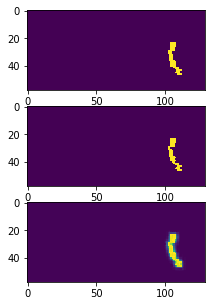

In [60]:
plt.figure(figsize=[15, 5])
plt.subplot(311)
plt.imshow(img_val.detach().cpu().squeeze())

plt.subplot(312)
plt.imshow(imgn_val.detach().cpu().squeeze())

plt.subplot(313)
plt.imshow(out_val.detach().cpu().squeeze())

# test it on real data

In [55]:
data_path = os.path.join(dataset_train.root, 'testdata')
real_data = sio.loadmat(os.path.join(data_path, 'real_2pdata.mat'))
A2p = real_data['A']
A2p_corr = real_data['A_corr']
A2p_raw = real_data['A_raw']

In [23]:
def plot_2p_results(neuron_id, cmap='jet'): 
#     img_raw = A_corr[:, :, neuron_id]
    img_raw = A2p_raw[:,:,neuron_id]

    noise = img_raw.std()
    img_raw = img_raw[np.newaxis, np.newaxis, ...] / noise * opt.noiseL
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A2p[:, :, neuron_id].squeeze()
    img_ai_raw = A2p_raw[:,:,neuron_id].squeeze()
    img_diff= img_ai_raw.squeeze() - img_ai
    
    img_diff = img_diff / noise * 0.1
    print(img_diff.shape)
    imgs = [img_raw.squeeze(), img_denoised.squeeze(), 
            img_output.squeeze(), img_ai/noise*0.1, img_diff]
    titles = ['unconstrained $a_i$', 'denoised $a_i$', 'residual', 'CNMF $a_i$', 'difference']
#     fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    plt.figure(figsize=(12, 8))
    vlims = [[-0.1,1], [-0.1,1], [-0.2, 0.2], [-0.1,1], [-0.2, 0.2]]
    for i, img, title, vlim in zip(range(len(imgs)), imgs, titles, vlims): 
        plt.subplot(2,5, i+1)
        im = plt.imshow(img, cmap=cmap, clim=vlim)
        plt.colorbar()
#         divider = make_axes_locatable(ax)
#         cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.title(title)
#         plt.colorbar(im, cax=cax)
    
#     plt.tight_layout()
    
    imgs = imgs[0:2]
    labels = ['raw image', 'denoised image']
#     plt.figure(figsize=(5, 8))
    plt.subplot(2,2,3)
    for i, img, label in zip(range(len(imgs)), imgs, labels): 
        __ = plt.hist(img.flatten(), bins=np.linspace(-0.1,1, 100), 
                     label=label)
        plt.yscale('log')
        plt.legend()

    plt.subplot(2,2, 4)
    plt.plot(img_raw.ravel(), img_denoised.ravel(), '.')
    plt.plot([-0.5, 2], [-0.5,2], c='r')
    plt.xlim([-0.1, 1])
    plt.ylim([-0.1, 1])
    plt.xlabel('raw pixel values')
    plt.ylabel('denoised pixel values')
#     plt.tight_layout()
    
    return img_raw, img_denoised

In [56]:
torch.save(model.state_dict(), os.path.join(opt.outf, 'net_{}_connector.pth'.format(opt.num_of_layers)))


In [57]:
dummy_input = torch.randn(1, 1, 60, 80, device='cuda')
file_onnx = os.path.join(opt.outf, 'net_{}_connector.onnx'.format(opt.num_of_layers))
torch.onnx.export(model, dummy_input, file_onnx)

(60, 80)


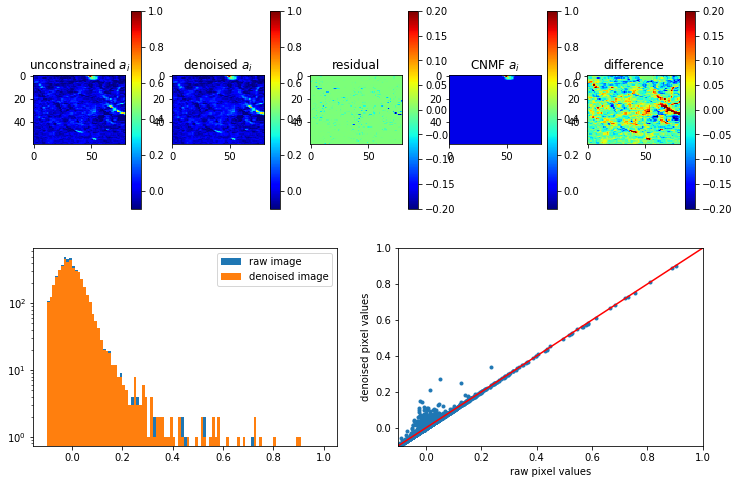

In [27]:
example_id = 2
img_raw, img_denoised = plot_2p_results(20)

Text(0.5, 1.0, 'NN-denoiser')

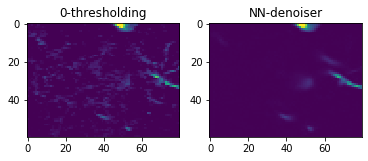

In [28]:
plt.subplot(121)
plt.imshow((img_raw * (img_raw>0)).squeeze(), clim=[0,1])
plt.title('0-thresholding')
plt.subplot(122)
plt.imshow(img_denoised.squeeze(), clim=[0,1])
plt.title('NN-denoiser')

# test baylor data 

In [34]:
real_data = sio.loadmat(os.path.join(data_path, 'baylor_data.mat'))
A = real_data['A']
A_corr = real_data['A_corr']
A_em = real_data['A_em']

In [35]:
def plot_baylor_results(neuron_id, plane_id, cmap='jet'): 
    img_raw = A_corr[:, :, plane_id, neuron_id].reshape(1,1, 58, 129)
    noise = img_raw[img_raw!=0].std()
    img_raw = img_raw / img_raw.max() 
    img_input = torch.Tensor(img_raw).cuda()
    img_output = model(img_input).detach().cpu().numpy()
    img_denoised = img_raw -img_output
    
    img_ai = A[:, :, plane_id, neuron_id].squeeze()
    img_pi = A_em[:,:,plane_id, neuron_id].squeeze()
    
    imgs = [img_pi/img_pi.max(), img_ai/img_ai.max(), img_raw.squeeze(), img_denoised.squeeze(), img_output.squeeze()]
    titles = ['EM footprint', '2P footprint', 'corr. image', 'denoised corr. image', 'residual']
    fig, axs = plt.subplots(len(imgs), 1, figsize=(18, 8))
    for img, title, ax in zip(imgs, titles, axs): 
        im = ax.imshow(img, cmap=cmap, clim=[-0.1, 0.5])
        ax.set_ylabel(title)
    

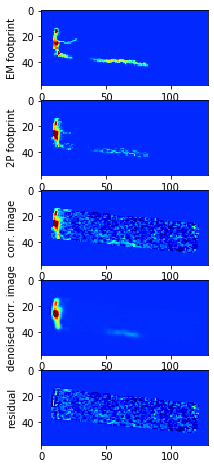

In [36]:
plot_baylor_results(5,2)

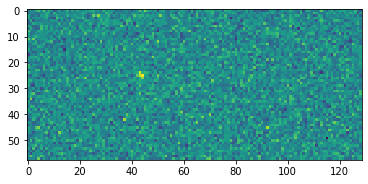

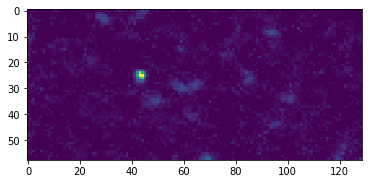

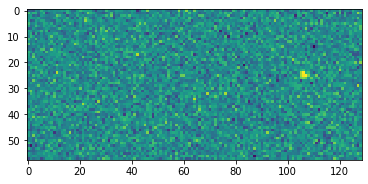

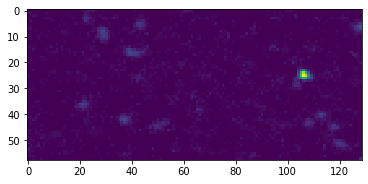

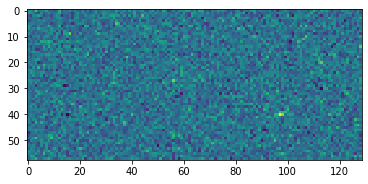

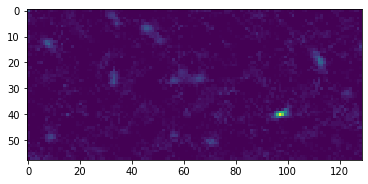

In [ ]:
#Here we visualize how well the model actually performs on the test data that we defined for it
for k in range(len(dataset_train)):
    img_val = torch.unsqueeze(dataset_val[k], 0)
    noise = torch.FloatTensor(img_val.size()).normal_(mean=0, std=opt.val_noiseL)
    imgn_val = img_val + noise
    img_val, imgn_val = Variable(img_val.cuda()), Variable(imgn_val.cuda())
    out_val = torch.clamp(imgn_val-model(imgn_val), 0., 1.)
    imgn_valCPU = imgn_val.detach().cpu().numpy()
    imgn_valCPU = imgn_valCPU.squeeze()
    out_valCPU = out_val.detach().cpu().numpy()
    out_valCPU = out_valCPU.squeeze()
    
    plt.figure()
    plt.imshow(imgn_valCPU)
    plt.figure()
    plt.imshow(out_valCPU)
    plt.show()
    input()
#     psnr_val += batch_PSNR(out_val, img_val, 1.)
# psnr_val /= len(dataset_val)